# TMA Initial Clustering & Core Selection

This notebook performs the initial HDBSCAN clustering step and allows you to:
1. Visualize the clustering results
2. Optionally merge cores that were incorrectly split
3. Select which cores look good (to save as-is)
4. Mark remaining cores for further refinement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import anndata

# Try GPU-accelerated cuML HDBSCAN, fall back to CPU hdbscan
try:
    from cuml.cluster import HDBSCAN
    import cupy as cp
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    USE_GPU = True
    print("Using GPU-accelerated cuML HDBSCAN")
except ImportError:
    from hdbscan import HDBSCAN
    USE_GPU = False
    print("cuML not available, using CPU HDBSCAN")

import os
import yaml
import warnings
warnings.filterwarnings('ignore')

Using GPU-accelerated cuML HDBSCAN


In [2]:
if USE_GPU:
    rmm.reinitialize(
        managed_memory=False,
        pool_allocator=True,
        devices=0,
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
CONFIG_PATH = "config/tma_dearray.yaml"

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

INPUT_FILE = config['input_file']
OUTPUT_DIR = config['output_dir']
OUTPUT_PREFIX = config['output_prefix']

EXPECTED_NUM_CORES = config['hdbscan']['expected_num_cores']
HDBSCAN_MIN_SAMPLES = config['hdbscan']['min_samples']
HDBSCAN_EPSILON = config['hdbscan']['cluster_selection_epsilon']

MERGE_CORES = [tuple(pair) for pair in config.get('merge_cores', [])]
GOOD_CORES = config.get('good_cores', [])

print(f"Loaded config from {CONFIG_PATH}")
print(f"Input: {INPUT_FILE}")
print(f"Output prefix: {OUTPUT_PREFIX}")
print(f"Expected cores: {EXPECTED_NUM_CORES}")

Loaded config from config/tma_dearray.yaml
Input: /scratch/ncostigan/tma/cp18_tma_1.h5ad
Output prefix: cp18_tma_1
Expected cores: 17


In [4]:
PLOT_DIR = os.path.join(OUTPUT_DIR, 'plots/tma_dearray', OUTPUT_PREFIX)
GOOD_CORES_DIR = os.path.join(OUTPUT_DIR, 'good_cores', OUTPUT_PREFIX)

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(GOOD_CORES_DIR, exist_ok=True)

print(f"Plots will be saved to: {PLOT_DIR}")
print(f"Good cores will be saved to: {GOOD_CORES_DIR}")

Plots will be saved to: ./datasets/tma/plots/tma_dearray/cp18_tma_1
Good cores will be saved to: ./datasets/tma/good_cores/cp18_tma_1


## Load Data

In [5]:
print("Loading AnnData...")
adata = anndata.read_h5ad(INPUT_FILE)
print(f"Loaded {adata.n_obs:,} cells with {adata.n_vars} genes")

spatial_coords = adata.obsm['spatial']
print(f"Spatial range: X [{spatial_coords[:,0].min():.1f}, {spatial_coords[:,0].max():.1f}]")
print(f"               Y [{spatial_coords[:,1].min():.1f}, {spatial_coords[:,1].max():.1f}]")

Loading AnnData...
Loaded 749,546 cells with 446 genes
Spatial range: X [3.5, 11450.0]
               Y [132.8, 23066.0]


## Spatial Distribution

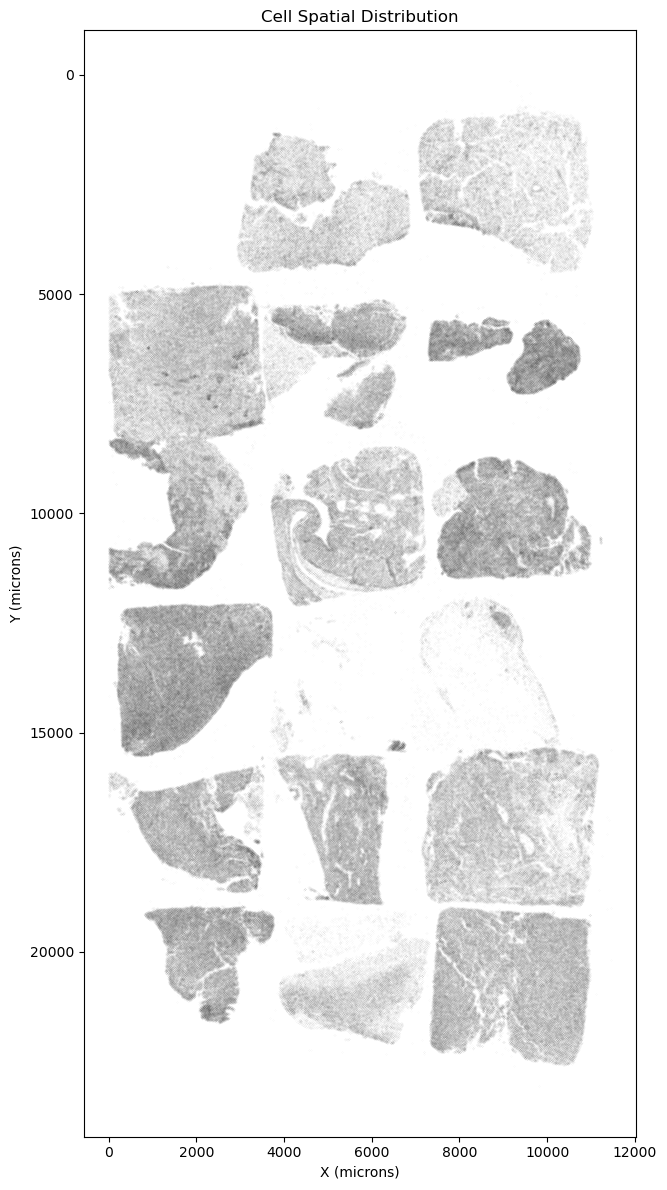

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
ax.scatter(spatial_coords[:,0], spatial_coords[:,1], s=0.01, alpha=0.1, c='black')
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title('Cell Spatial Distribution')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f'{OUTPUT_PREFIX}_spatial_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## HDBSCAN Clustering

In [7]:
# Estimate min_cluster_size based on expected cores
estimated_cells_per_core = adata.n_obs // EXPECTED_NUM_CORES
min_cluster_size = max(1000, estimated_cells_per_core // 10)

print(f"Estimated cells per core: {estimated_cells_per_core:,}")
print(f"Using min_cluster_size: {min_cluster_size:,}")

Estimated cells per core: 44,090
Using min_cluster_size: 4,409


In [8]:
%%time
print("Running HDBSCAN clustering...")

hdbscan_kwargs = {
    'min_cluster_size': min_cluster_size,
    'min_samples': HDBSCAN_MIN_SAMPLES,
    'cluster_selection_epsilon': HDBSCAN_EPSILON,
    'metric': 'euclidean',
}
if not USE_GPU:
    hdbscan_kwargs['core_dist_n_jobs'] = -1

clusterer = HDBSCAN(**hdbscan_kwargs)
labels = clusterer.fit_predict(spatial_coords)

if USE_GPU and hasattr(labels, 'get'):
    labels = labels.get()

print("Clustering complete!")

Running HDBSCAN clustering...
Clustering complete!
CPU times: user 24.6 s, sys: 11.1 s, total: 35.7 s
Wall time: 36 s


In [9]:
unique_labels = np.unique(labels)
n_clusters = len(unique_labels[unique_labels >= 0])
n_noise = (labels == -1).sum()

print(f"\nClusters found: {n_clusters}")
print(f"Noise points (unassigned): {n_noise:,} ({100*n_noise/len(labels):.1f}%)")

print("\nCells per cluster:")
for label in sorted(unique_labels):
    count = (labels == label).sum()
    name = f"Core {label+1}" if label >= 0 else "Noise"
    print(f"  {name}: {count:,} cells ({100*count/len(labels):.1f}%)")


Clusters found: 16
Noise points (unassigned): 929 (0.1%)

Cells per cluster:
  Noise: 929 cells (0.1%)
  Core 1: 33,203 cells (4.4%)
  Core 2: 22,495 cells (3.0%)
  Core 3: 14,870 cells (2.0%)
  Core 4: 63,707 cells (8.5%)
  Core 5: 95,053 cells (12.7%)
  Core 6: 41,736 cells (5.6%)
  Core 7: 145,329 cells (19.4%)
  Core 8: 66,185 cells (8.8%)
  Core 9: 39,289 cells (5.2%)
  Core 10: 9,033 cells (1.2%)
  Core 11: 49,738 cells (6.6%)
  Core 12: 73,438 cells (9.8%)
  Core 13: 41,164 cells (5.5%)
  Core 14: 19,477 cells (2.6%)
  Core 15: 22,254 cells (3.0%)
  Core 16: 11,646 cells (1.6%)


In [10]:
def get_distinct_colors(n):
    """Generate n colors where adjacent indices are maximally different.
    
    Uses golden angle (137.5 deg) sampling of HSV hue space.
    """
    colors = []
    golden_angle = 137.508
    for i in range(n):
        hue = (i * golden_angle) % 360 / 360
        rgb = plt.cm.hsv(hue)
        colors.append(rgb)
    return colors

## HDBSCAN Clusters

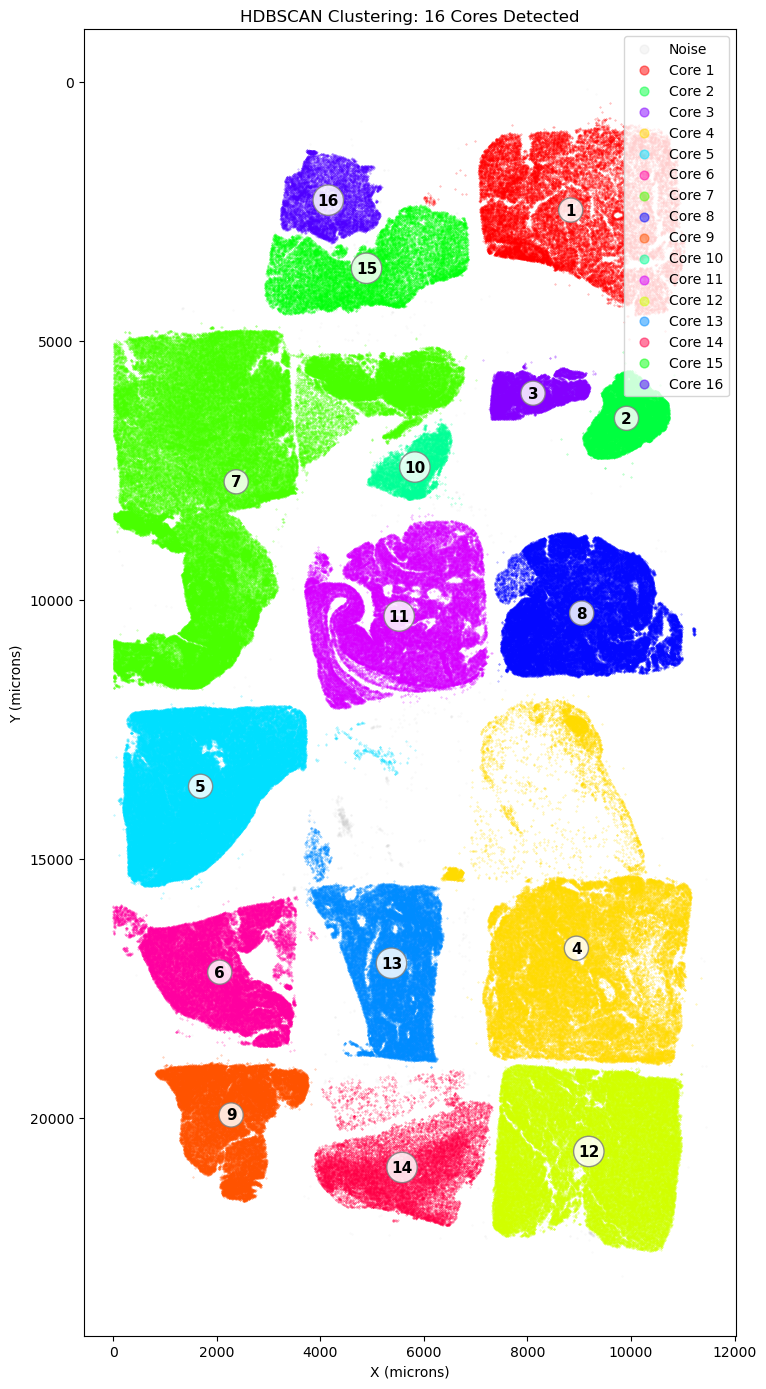

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

n_clusters_actual = len([l for l in unique_labels if l >= 0])
colors = get_distinct_colors(max(n_clusters_actual, 20))

for label in sorted(unique_labels):
    mask = labels == label
    if label == -1:
        ax.scatter(
            spatial_coords[mask, 0],
            spatial_coords[mask, 1],
            s=0.1, alpha=0.2, c='lightgray', label='Noise'
        )
    else:
        ax.scatter(
            spatial_coords[mask, 0],
            spatial_coords[mask, 1],
            s=0.1, alpha=0.5, c=[colors[label]], label=f'Core {label+1}'
        )
        # Add core number label at centroid
        cx = spatial_coords[mask, 0].mean()
        cy = spatial_coords[mask, 1].mean()
        ax.text(cx, cy, f"{label+1}", fontsize=11, fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='circle', facecolor='white', alpha=0.85, edgecolor='gray'))

ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title(f'HDBSCAN Clustering: {n_clusters} Cores Detected')
ax.legend(markerscale=20, loc='upper right')
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f'{OUTPUT_PREFIX}_hdbscan_clusters.png'), dpi=150, bbox_inches='tight')
plt.show()

## Individual Cores Grid

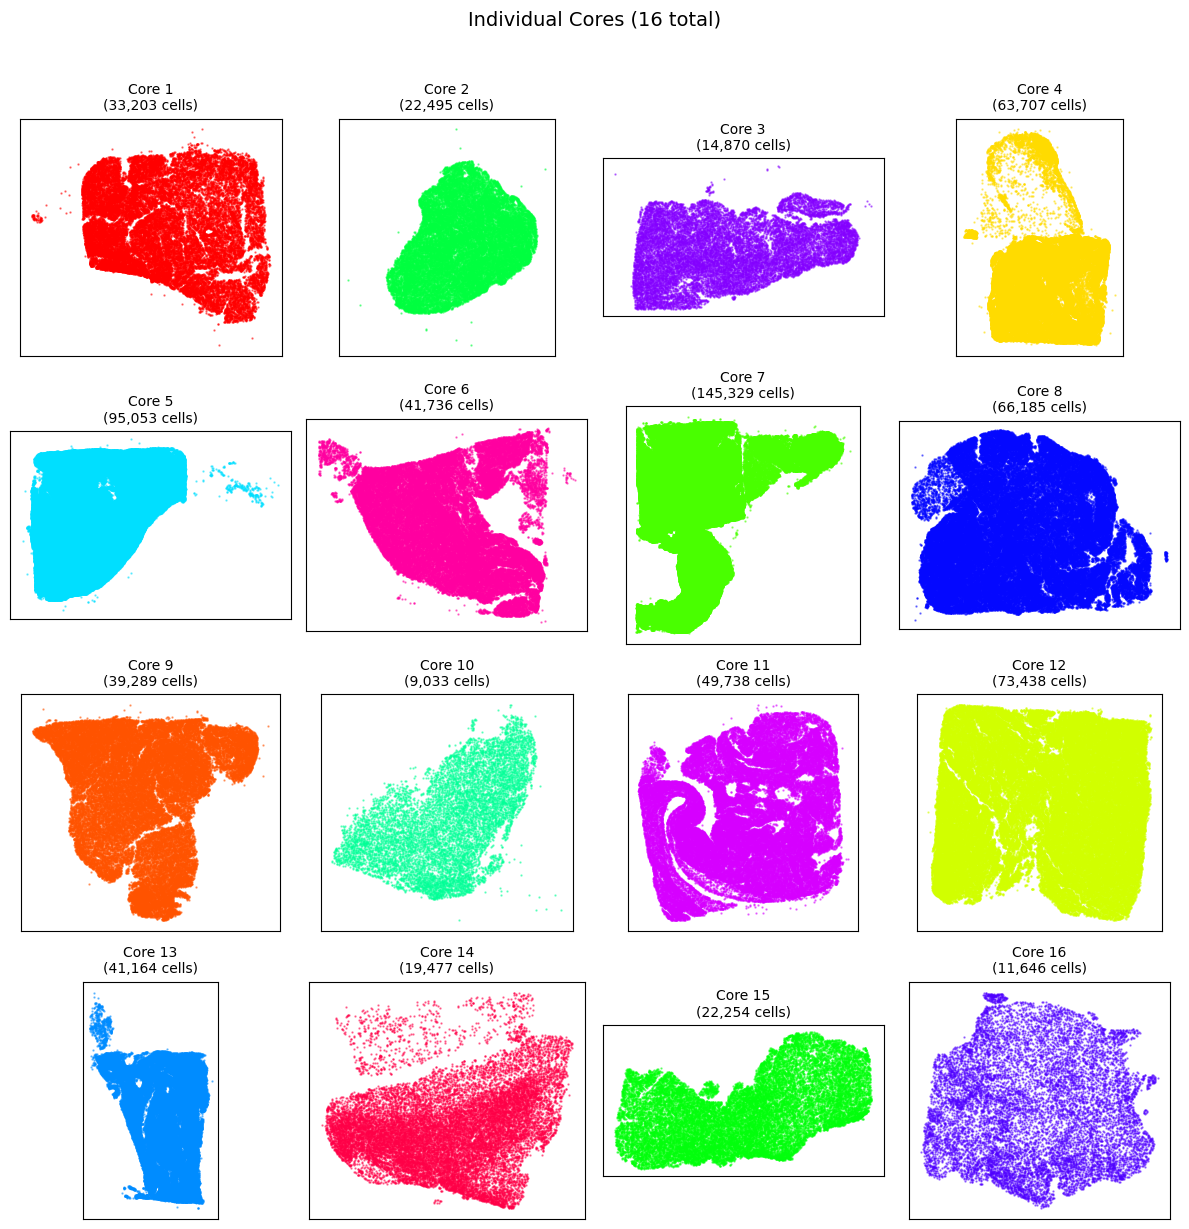

In [12]:
core_labels = sorted([l for l in unique_labels if l >= 0])
n_cores_to_plot = len(core_labels)

n_cols = int(np.ceil(np.sqrt(n_cores_to_plot)))
n_rows = int(np.ceil(n_cores_to_plot / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = np.atleast_2d(axes)

for idx, label in enumerate(core_labels):
    row, col = idx // n_cols, idx % n_cols
    ax = axes[row, col]
    
    mask = labels == label
    core_coords = spatial_coords[mask]
    
    ax.scatter(
        core_coords[:, 0],
        core_coords[:, 1],
        s=0.5, alpha=0.5, c=[colors[label]]
    )
    
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Core {label+1}\n({mask.sum():,} cells)', fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

for idx in range(n_cores_to_plot, n_rows * n_cols):
    row, col = idx // n_cols, idx % n_cols
    axes[row, col].axis('off')

plt.suptitle(f'Individual Cores ({n_cores_to_plot} total)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f'{OUTPUT_PREFIX}_individual_cores_grid.png'), dpi=150, bbox_inches='tight')
plt.show()

## (Optional) Merge Cores

If HDBSCAN has split what should be a single core into multiple clusters, you can merge them.

Set `merge_cores` in the config YAML or override manually below.

In [13]:
# Manual override (uncomment and edit to override config values)
# MERGE_CORES = [(5, 6), (1, 2)]  # merge core 6 into 5, core 2 into 1

MERGE_CORES = [(3, 2), (15, 16)] 
print(f"MERGE_CORES = {MERGE_CORES}")

MERGE_CORES = [(3, 2), (15, 16)]


In [14]:
if MERGE_CORES:
    labels_merged = labels.copy()
    
    for keep_core, merge_core in MERGE_CORES:
        keep_idx = keep_core - 1
        merge_idx = merge_core - 1
        
        keep_count = (labels_merged == keep_idx).sum()
        merge_count = (labels_merged == merge_idx).sum()
        
        labels_merged[labels_merged == merge_idx] = keep_idx
        
        print(f"Merged Core {merge_core} ({merge_count:,} cells) into Core {keep_core} ({keep_count:,} cells)")
        print(f"  -> Core {keep_core} now has {(labels_merged == keep_idx).sum():,} cells")
    
    labels = labels_merged
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels >= 0])
    n_noise = (labels == -1).sum()
    
    print(f"\nAfter merging: {n_clusters} cores")
else:
    print("No merges specified - skipping merge step")

Merged Core 2 (22,495 cells) into Core 3 (14,870 cells)
  -> Core 3 now has 37,365 cells
Merged Core 16 (11,646 cells) into Core 15 (22,254 cells)
  -> Core 15 now has 33,900 cells

After merging: 14 cores


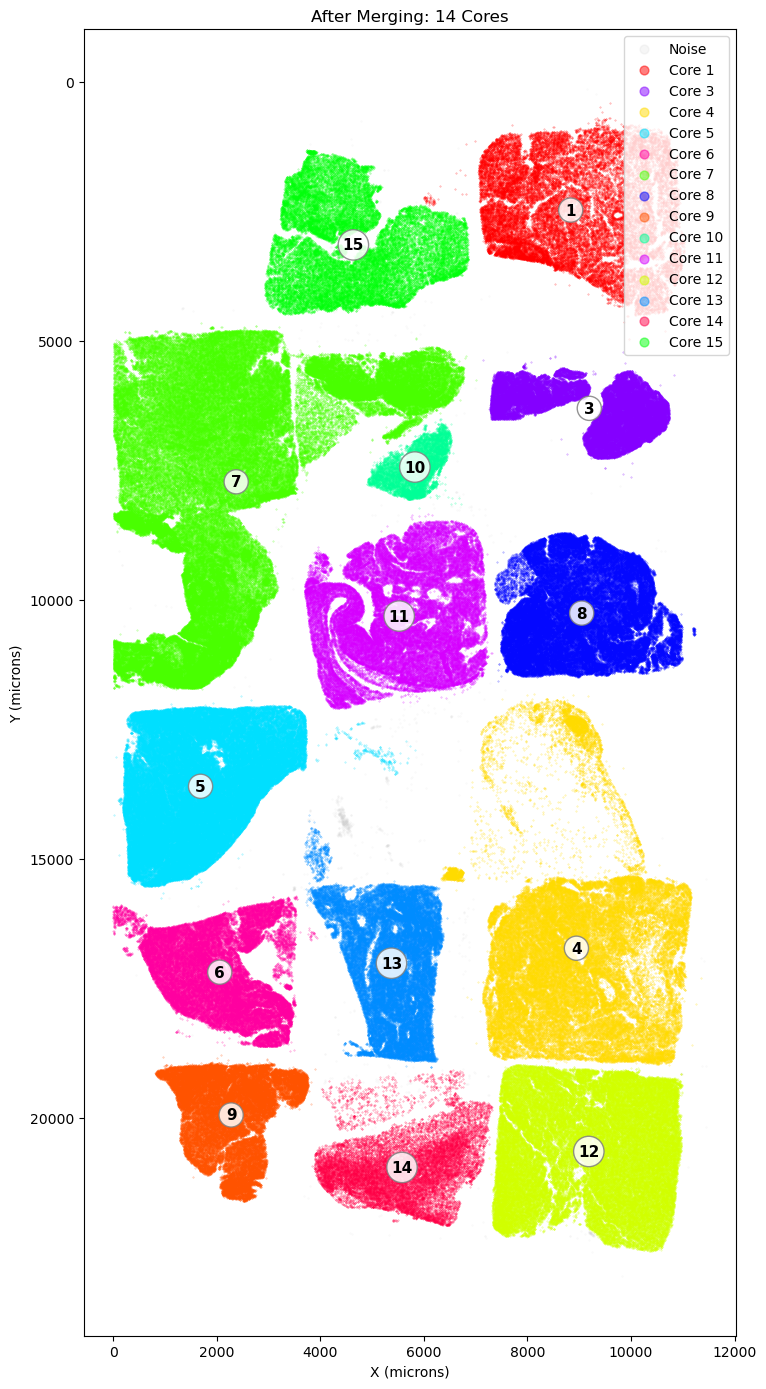

In [15]:
if MERGE_CORES:
    fig, ax = plt.subplots(1, 1, figsize=(12, 14))
    
    colors = get_distinct_colors(max(len([l for l in unique_labels if l >= 0]), 20))
    
    for label in sorted(unique_labels):
        mask = labels == label
        if label == -1:
            ax.scatter(
                spatial_coords[mask, 0],
                spatial_coords[mask, 1],
                s=0.1, alpha=0.2, c='lightgray', label='Noise'
            )
        else:
            ax.scatter(
                spatial_coords[mask, 0],
                spatial_coords[mask, 1],
                s=0.1, alpha=0.5, c=[colors[label]], label=f'Core {label+1}'
            )
            cx = spatial_coords[mask, 0].mean()
            cy = spatial_coords[mask, 1].mean()
            ax.text(cx, cy, f"{label+1}", fontsize=11, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle='circle', facecolor='white', alpha=0.85, edgecolor='gray'))
    
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_xlabel('X (microns)')
    ax.set_ylabel('Y (microns)')
    ax.set_title(f'After Merging: {n_clusters} Cores')
    ax.legend(markerscale=20, loc='upper right')
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, f'{OUTPUT_PREFIX}_after_merge.png'), dpi=150, bbox_inches='tight')
    plt.show()

## Core Selection

Review the plots above and select which cores look good.

Set `good_cores` in the config YAML or override manually below.

In [16]:
# Manual override (uncomment and edit to override config values)
# GOOD_CORES = [1, 3, 5, 7, 8]  # 1-indexed core numbers

GOOD_CORES = [1, 3, 6, 8, 9, 11, 12, 14, 15] 

print(f"GOOD_CORES = {GOOD_CORES}")

GOOD_CORES = [1, 3, 6, 8, 9, 11, 12, 14, 15]


In [17]:
good_core_indices = [c - 1 for c in GOOD_CORES]
all_core_indices = [l for l in unique_labels if l >= 0]
remaining_core_indices = [c for c in all_core_indices if c not in good_core_indices]

print(f"Total cores detected: {len(all_core_indices)}")
print(f"Good cores (will be saved): {len(good_core_indices)}")
print(f"  Core numbers: {[c+1 for c in good_core_indices]}")
print(f"Remaining cores: {len(remaining_core_indices)}")
print(f"  Core numbers: {[c+1 for c in remaining_core_indices]}")

Total cores detected: 14
Good cores (will be saved): 9
  Core numbers: [1, 3, 6, 8, 9, 11, 12, 14, 15]
Remaining cores: 5
  Core numbers: [np.int32(4), np.int32(5), np.int32(7), np.int32(10), np.int32(13)]


## Visualize Selection

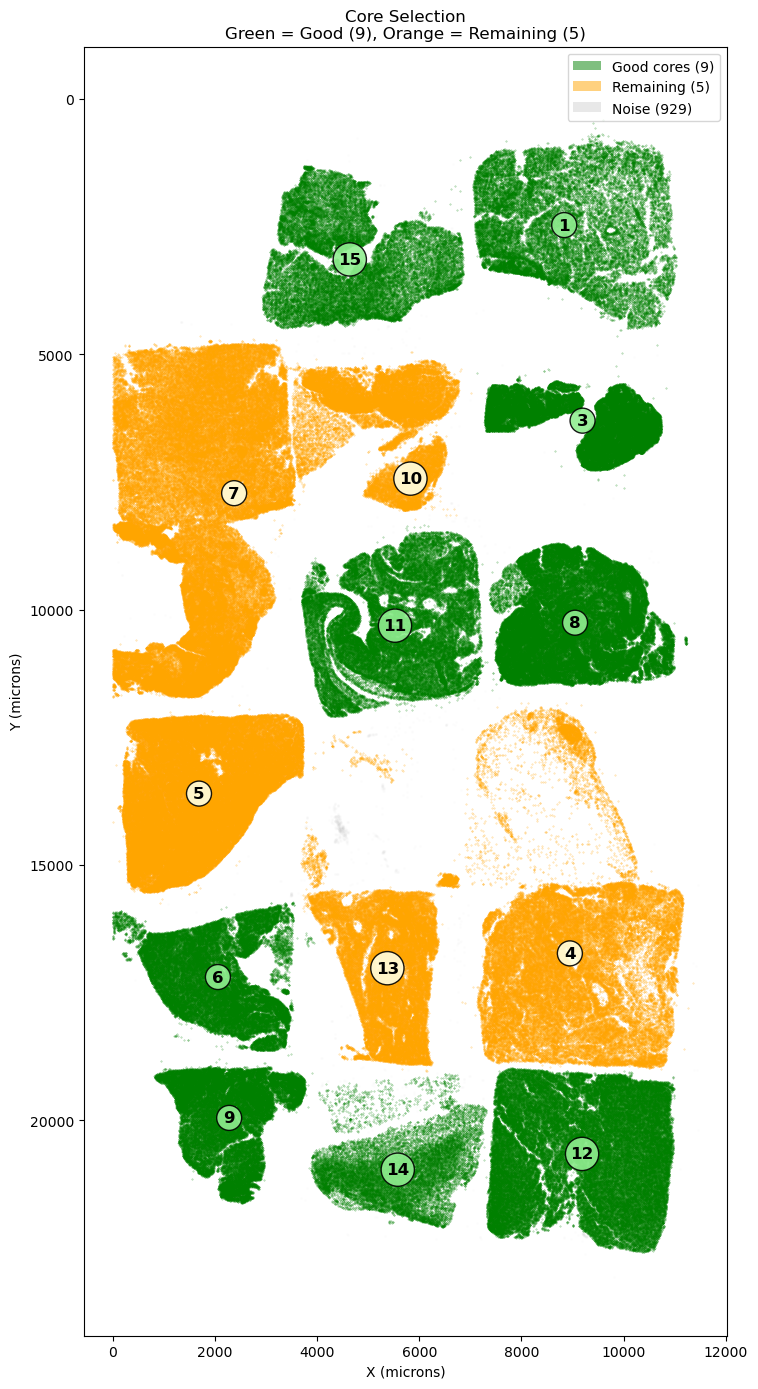

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

for label in good_core_indices:
    mask = labels == label
    ax.scatter(
        spatial_coords[mask, 0],
        spatial_coords[mask, 1],
        s=0.1, alpha=0.5, c='green'
    )
    cx = spatial_coords[mask, 0].mean()
    cy = spatial_coords[mask, 1].mean()
    ax.text(cx, cy, f"{label+1}", fontsize=12, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='circle', facecolor='lightgreen', alpha=0.9))

for label in remaining_core_indices:
    mask = labels == label
    ax.scatter(
        spatial_coords[mask, 0],
        spatial_coords[mask, 1],
        s=0.1, alpha=0.5, c='orange'
    )
    cx = spatial_coords[mask, 0].mean()
    cy = spatial_coords[mask, 1].mean()
    ax.text(cx, cy, f"{label+1}", fontsize=12, fontweight='bold',
            ha='center', va='center',
            bbox=dict(boxstyle='circle', facecolor='lightyellow', alpha=0.9))

noise_mask = labels == -1
if noise_mask.any():
    ax.scatter(
        spatial_coords[noise_mask, 0],
        spatial_coords[noise_mask, 1],
        s=0.1, alpha=0.1, c='lightgray'
    )

ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('X (microns)')
ax.set_ylabel('Y (microns)')
ax.set_title(f'Core Selection\nGreen = Good ({len(good_core_indices)}), Orange = Remaining ({len(remaining_core_indices)})')

legend_elements = [
    Patch(facecolor='green', alpha=0.5, label=f'Good cores ({len(good_core_indices)})'),
    Patch(facecolor='orange', alpha=0.5, label=f'Remaining ({len(remaining_core_indices)})'),
    Patch(facecolor='lightgray', alpha=0.5, label=f'Noise ({noise_mask.sum():,})')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, f'{OUTPUT_PREFIX}_core_selection.png'), dpi=150, bbox_inches='tight')
plt.show()

## Save Results

In [19]:
adata.obs['tma_core'] = labels
adata.obs['tma_core_label'] = adata.obs['tma_core'].apply(
    lambda x: f"Core_{x+1}" if x >= 0 else "Unassigned"
)

def get_status(core_id):
    if core_id < 0:
        return "unassigned"
    elif core_id in good_core_indices:
        return "good"
    else:
        return "remaining"

adata.obs['core_status'] = adata.obs['tma_core'].apply(get_status)

print("Added columns to adata.obs:")
print("  - tma_core: cluster index (-1 for noise)")
print("  - tma_core_label: human-readable core label")
print("  - core_status: 'good', 'remaining', or 'unassigned'")
print()
print(adata.obs['core_status'].value_counts())

Added columns to adata.obs:
  - tma_core: cluster index (-1 for noise)
  - tma_core_label: human-readable core label
  - core_status: 'good', 'remaining', or 'unassigned'

core_status
good          394331
remaining     354286
unassigned       929
Name: count, dtype: int64


In [20]:
good_mask = adata.obs['core_status'] == 'good'

saved_cores = []

if good_mask.sum() > 0:
    print("Saving individual good cores with reset coordinates...")
    print("-" * 50)
    
    for core_idx in good_core_indices:
        core_num = core_idx + 1
        core_mask = adata.obs['tma_core'] == core_idx
        
        if core_mask.sum() == 0:
            continue
        
        adata_core = adata[core_mask].copy()
        
        orig_coords = adata_core.obsm['spatial'].copy()
        x_min = orig_coords[:, 0].min()
        y_min = orig_coords[:, 1].min()
        reset_coords = orig_coords - np.array([x_min, y_min])
        
        adata_core.obsm['spatial'] = reset_coords
        adata_core.obsm['spatial_original'] = orig_coords
        adata_core.uns['spatial_offset'] = {'x_min': float(x_min), 'y_min': float(y_min)}
        
        output_path = os.path.join(GOOD_CORES_DIR, f'core_{core_num:02d}.h5ad')
        adata_core.write_h5ad(output_path)
        saved_cores.append((core_num, adata_core.n_obs, output_path))
        
        print(f"  Core {core_num}: {adata_core.n_obs:,} cells")
        print(f"    Original range: X [{orig_coords[:,0].min():.1f}, {orig_coords[:,0].max():.1f}], Y [{orig_coords[:,1].min():.1f}, {orig_coords[:,1].max():.1f}]")
        print(f"    Reset range:    X [{reset_coords[:,0].min():.1f}, {reset_coords[:,0].max():.1f}], Y [{reset_coords[:,1].min():.1f}, {reset_coords[:,1].max():.1f}]")
        print(f"    Saved to: {os.path.basename(output_path)}")
    
    print("-" * 50)
    print(f"Saved {len(saved_cores)} good cores to: {GOOD_CORES_DIR}")
else:
    print("No good cores selected - skipping good cores output")

Saving individual good cores with reset coordinates...
--------------------------------------------------
  Core 1: 33,203 cells
    Original range: X [5998.4, 11033.1], Y [413.2, 4972.3]
    Reset range:    X [0.0, 5034.7], Y [0.0, 4559.2]
    Saved to: core_01.h5ad
  Core 3: 37,365 cells
    Original range: X [7135.5, 10837.5], Y [5226.2, 7624.7]
    Reset range:    X [0.0, 3702.0], Y [0.0, 2398.6]
    Saved to: core_03.h5ad
  Core 6: 41,736 cells
    Original range: X [3.5, 3946.4], Y [15728.2, 18710.8]
    Reset range:    X [0.0, 3942.9], Y [0.0, 2982.6]
    Saved to: core_06.h5ad
  Core 8: 66,185 cells
    Original range: X [7370.1, 11235.4], Y [8703.1, 11572.3]
    Reset range:    X [0.0, 3865.3], Y [0.0, 2869.1]
    Saved to: core_08.h5ad
  Core 9: 39,289 cells
    Original range: X [817.6, 3902.9], Y [18789.8, 21615.4]
    Reset range:    X [0.0, 3085.3], Y [0.0, 2825.6]
    Saved to: core_09.h5ad
  Core 11: 49,738 cells
    Original range: X [3696.2, 7325.3], Y [8353.6, 12093.

In [21]:
print("\n" + "="*50)
print("Summary")
print("="*50)
print(f"\nTotal cells: {adata.n_obs:,}")
print(f"Cores detected: {n_clusters}")
print(f"\nGood cores: {len(good_core_indices)} ({good_mask.sum():,} cells)")
print(f"Remaining cores: {len(remaining_core_indices)}")
print(f"\nOutputs:")
if saved_cores:
    print(f"  Good cores directory: {GOOD_CORES_DIR}")
    for core_num, n_cells, path in saved_cores:
        print(f"    - {os.path.basename(path)} ({n_cells:,} cells)")
    print(f"\n  Note: Each core has 'spatial' (reset to 0,0) and 'spatial_original' coordinates")
    print(f"        Original offset stored in adata.uns['spatial_offset']")

if remaining_core_indices:
    print(f"\n  Remaining cores not saved: {[c+1 for c in remaining_core_indices]}")
    for idx in remaining_core_indices:
        core_cells = (labels == idx).sum()
        print(f"    Core {idx+1}: {core_cells:,} cells")


Summary

Total cells: 749,546
Cores detected: 14

Good cores: 9 (394,331 cells)
Remaining cores: 5

Outputs:
  Good cores directory: ./datasets/tma/good_cores/cp18_tma_1
    - core_01.h5ad (33,203 cells)
    - core_03.h5ad (37,365 cells)
    - core_06.h5ad (41,736 cells)
    - core_08.h5ad (66,185 cells)
    - core_09.h5ad (39,289 cells)
    - core_11.h5ad (49,738 cells)
    - core_12.h5ad (73,438 cells)
    - core_14.h5ad (19,477 cells)
    - core_15.h5ad (33,900 cells)

  Note: Each core has 'spatial' (reset to 0,0) and 'spatial_original' coordinates
        Original offset stored in adata.uns['spatial_offset']

  Remaining cores not saved: [np.int32(4), np.int32(5), np.int32(7), np.int32(10), np.int32(13)]
    Core 4: 63,707 cells
    Core 5: 95,053 cells
    Core 7: 145,329 cells
    Core 10: 9,033 cells
    Core 13: 41,164 cells
